In [1]:
import re
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pathfile = r'C:\Users\renoip\disser'
dataset_file = pathlib.Path(pathfile).joinpath('data')

### First of all, it was necessary to read all the documents.

In [2]:
lines = ''
patients = []
docs = [file for file in dataset_file.iterdir() if file.suffix == '.txt']
for file in docs:
    tables = []
    with open(file, 'rt') as f:
        for line in f:
            line = re.sub(r'[0-9]+', '', line)
            tables.append(line)
    patients.append(tables)

### To reduce the number of word forms, it is necessary to lemmatize

In [3]:
# pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

for j in range(len(patients)):
    new_tables = []
    for i in range(len(patients[j])):
        words = patients[j][i].split()
        new_words = []
        for word in words:
            p = morph.parse(word)[0]
            new_words.append(p.normal_form)
        new_tables.append(new_words)
                
    patients[j] = new_tables

### If no changes were found during the examination, then it is necessary to repeat the result of the previous examination in history and calculate the duration of treatment

In [4]:
days = []
for j in range(len(patients)):
    for k in range(len(patients[j])):
        if patients[j][k] in [['..', ':'], ['...'], ['..'], []]:
            patients[j][k] = patients[j][k-1]
    days.append(len(patients[j]))

### For tf-idf, all words must be combined back into sentences.

In [5]:
"""преобразование таблиц"""
lines = []
for j in range(len(patients)):
    line = ''
    for k in range(len(patients[j])):
        line += ' '.join(patients[j][k])
    lines.append(line)

### We use the nltk library to get a list of stop words of the Russian language

In [6]:
"""uncomment this for the fist run"""
#pip install nltk
# import nltk
# nltk.download('stopwords')

'uncomment this for the fist run'

### We will expand the list of stop words in our own words

In [7]:
"""tf-idf"""
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

additional_stop_words = ['дата','время','осмотра','номер','пациента', 
              'локальный','статус','при','по', "под", 'осмотр', 'жалобы', 'пол',
              'возраст','мужской','женский', 'loc', 'localis', 'st', 'нет', 'не']
russian_stopwords = stopwords.words("russian")
russian_stopwords += additional_stop_words
vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,3))
matrix = vectorizer.fit_transform(lines).toarray()
df = pd.DataFrame(data=matrix)
df.columns = vectorizer.get_feature_names()
df.head()

,абсцесс,абсцесс учитывать,абсцесс учитывать практически,ад,ад боль,ад боль сустав,аденита,аденита ангоита,аденита ангоита боль,аксилярный,...,яркий горячий ощупь,яркий пигментация,яркий пигментация кожа,яркий чёткий,яркий чёткий границами,яркий эритема,яркий эритема горячий,ясные,ясные живот,ясные живот мягкий
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add the number of days in the hospital and normalize

In [8]:
from sklearn.preprocessing import Normalizer
df['number of days'] = days
df_normalized = Normalizer(norm='l2').fit_transform(df)

### PCA

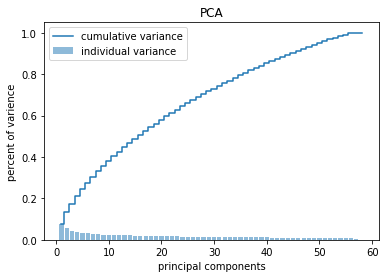

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(df_normalized)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(1,df_normalized.shape[0]+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual variance')
plt.step(range(1,df_normalized.shape[0]+1), cum_var_exp, where='mid', label='cumulative variance')
plt.ylabel('percent of varience')
plt.xlabel('principal components')
plt.legend(loc='best')
plt.title('PCA')
plt.show()

The analysis of the main components did not give any results, since the entire dispersion is described by 60 components

### Group the days in the hospital and apply other dimensional reduction methods such as UMAP, ISOMAP, MDS and TNSE with PCA

We divide patients into 3 groups:
1. less than 10 days in the hospital
2. in the hospital from 10 to 12 days
3. the hospital has more than 12 days

In [10]:
df['days_groups'] = 2
indexes = df[df['number of days']<=9].index
df.loc[indexes, 'days_groups'] = 1
indexes = df[df['number of days']>=13].index
df.loc[indexes, 'days_groups'] = 3
days_groups = df['days_groups'].values
colors = len(set(days_groups))

In [11]:
def draw_plot(fit, title, n, ax_list, data=df_normalized):
    results = fit.fit_transform(data);
    
    subset = pd.DataFrame()
    subset['one'] = results[:,0]
    subset['two'] = results[:,1]
    
    ax = plt.subplot(1, 5, n)
    ax_list.append(ax)
    sns.scatterplot(
    x="one", y="two",
    hue=days_groups,
    palette=sns.color_palette("muted", colors),
    data=subset,
    legend='brief',
    alpha=1,
    ax=ax_list[n-1]
    )
    
    for i in range(results.shape[0]):
        plt.annotate(i, xy=(results[i,0], results[i,1]))
    
    plt.title(title, fontsize=18)

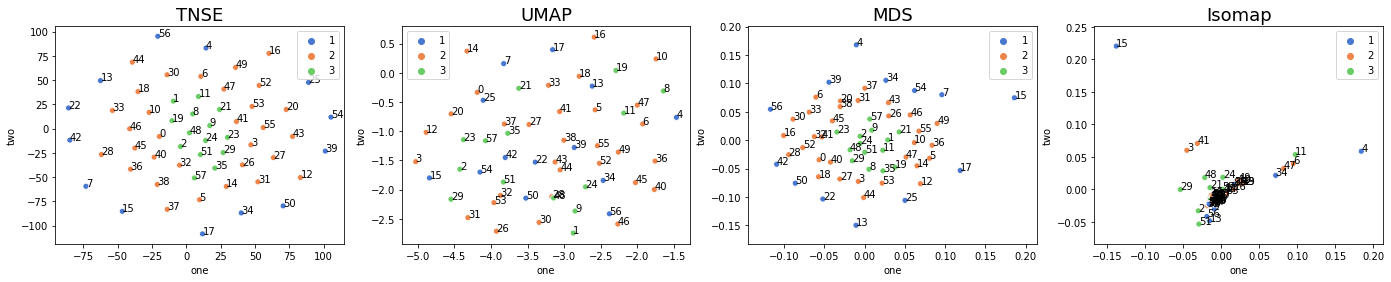

In [12]:
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
import umap #pip(conda) install umap-learn

names = ["TNSE", "UMAP", "MDS", "Isomap"]

methods = [
    TSNE(n_components=2),
    umap.UMAP(),
    MDS(n_components=2),
    Isomap(n_components=2)]

ax_list = []
plt.figure(figsize=(30,4))

for i in range(1,len(methods)+1):
    draw_plot(methods[i-1], names[i-1], i, ax_list)

### Select isomap parameters

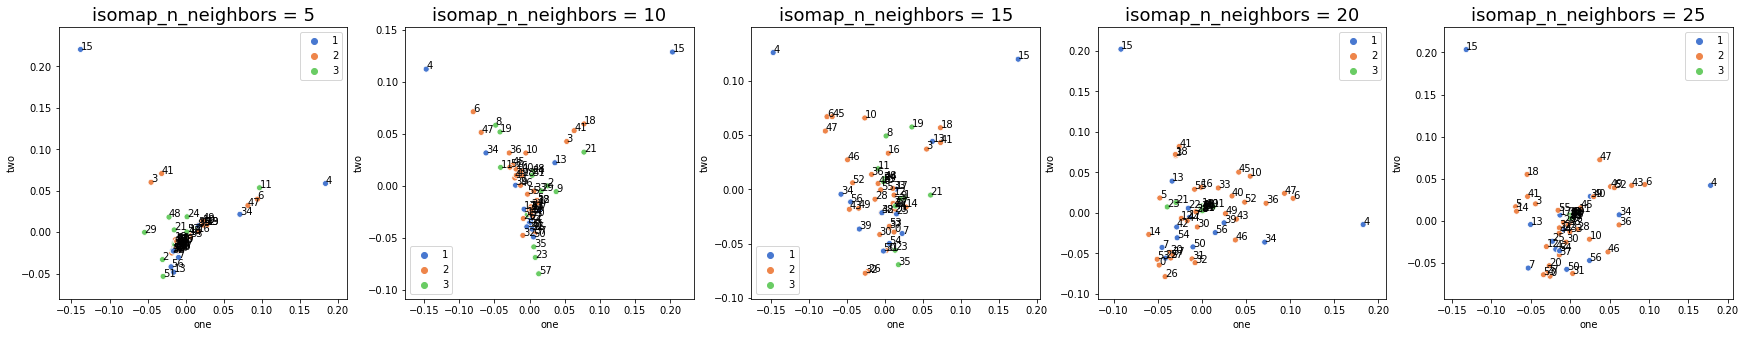

In [13]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = Isomap(
        n_neighbors=n*5,
        n_components=2)
    title='isomap_n_neighbors = {}'.format(n*5)
    draw_plot(fit, title, n, ax_list)

### Select UMAP parameters

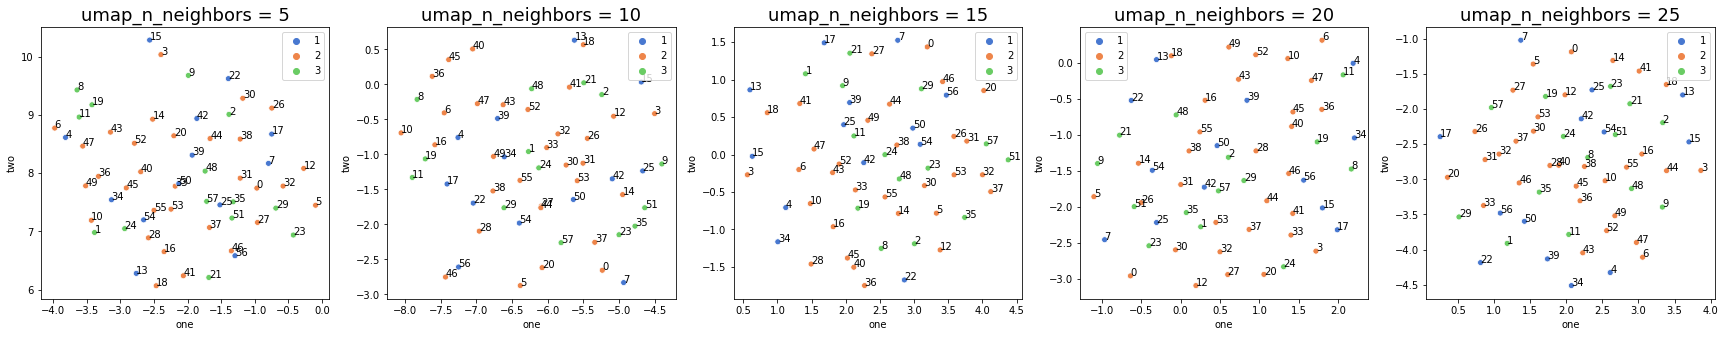

In [14]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = umap.UMAP(
        n_neighbors=n*5,
        n_components=2)
    title='umap_n_neighbors = {}'.format(n*5)
    draw_plot(fit, title, n, ax_list)

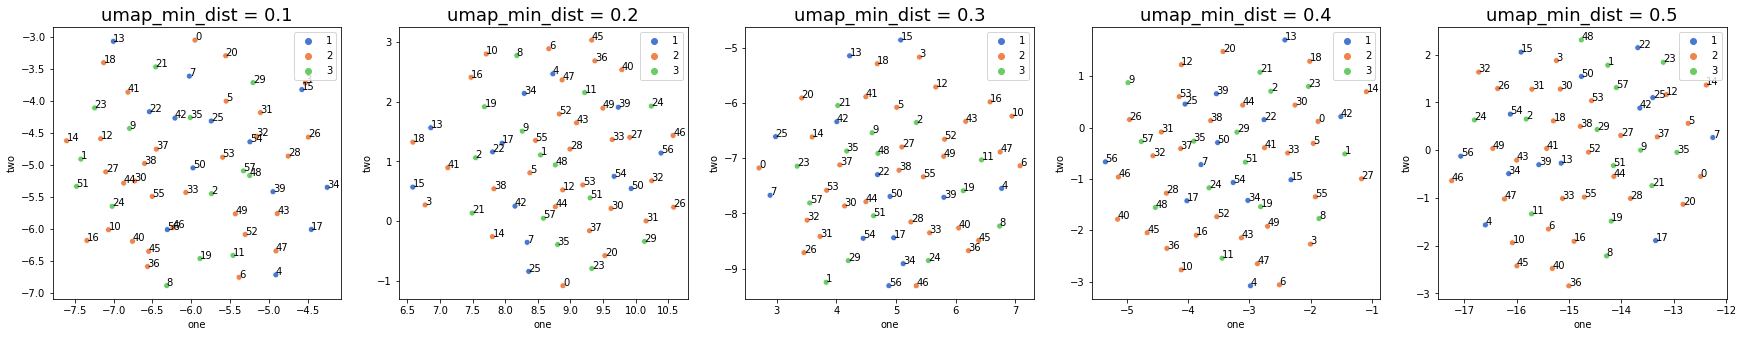

In [15]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = umap.UMAP(
        min_dist=n/10,
        n_components=2)
    title='umap_min_dist = {}'.format(n/10)
    draw_plot(fit, title, n, ax_list)

### Select TNSE parameters

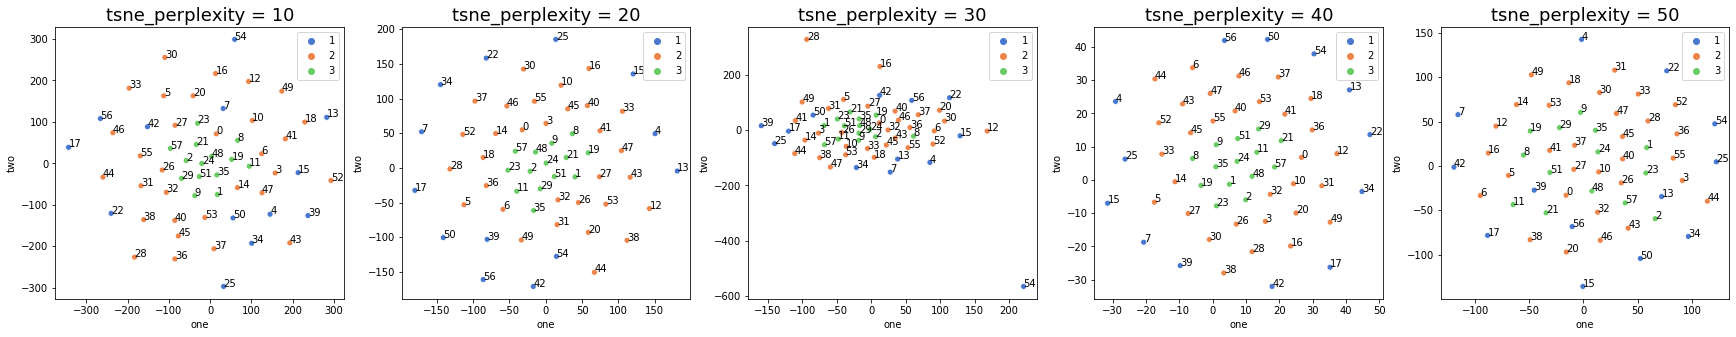

In [16]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = TSNE(
        perplexity=n*10,
        n_components=2)
    title='tsne_perplexity = {}'.format(n*10)
    draw_plot(fit, title, n, ax_list)

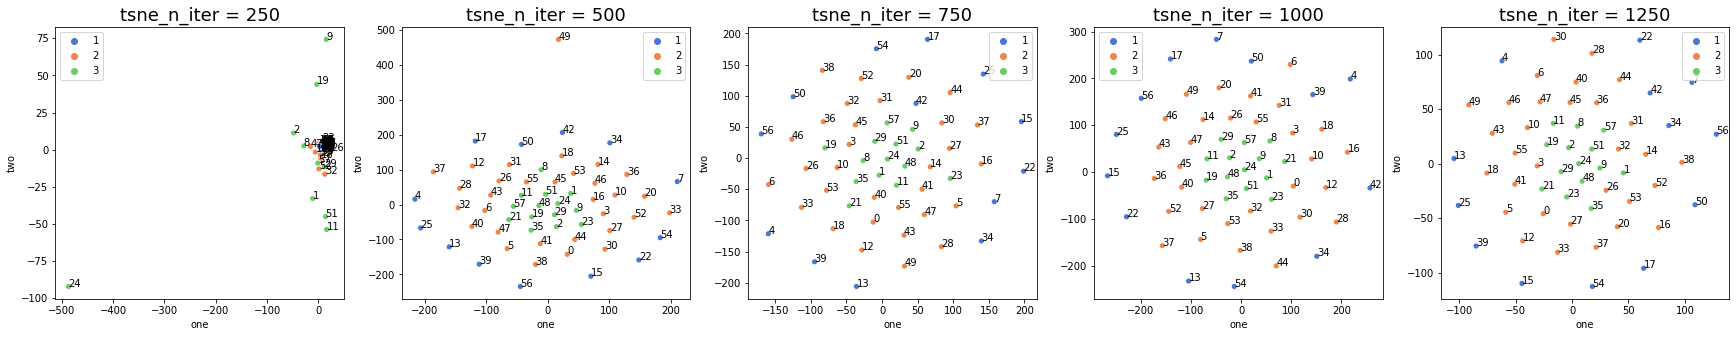

In [17]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = TSNE(
        n_iter=n*250,
        n_components=2)
    title='tsne_n_iter = {}'.format(n*250)
    draw_plot(fit, title, n, ax_list)

### Select MDS parameters

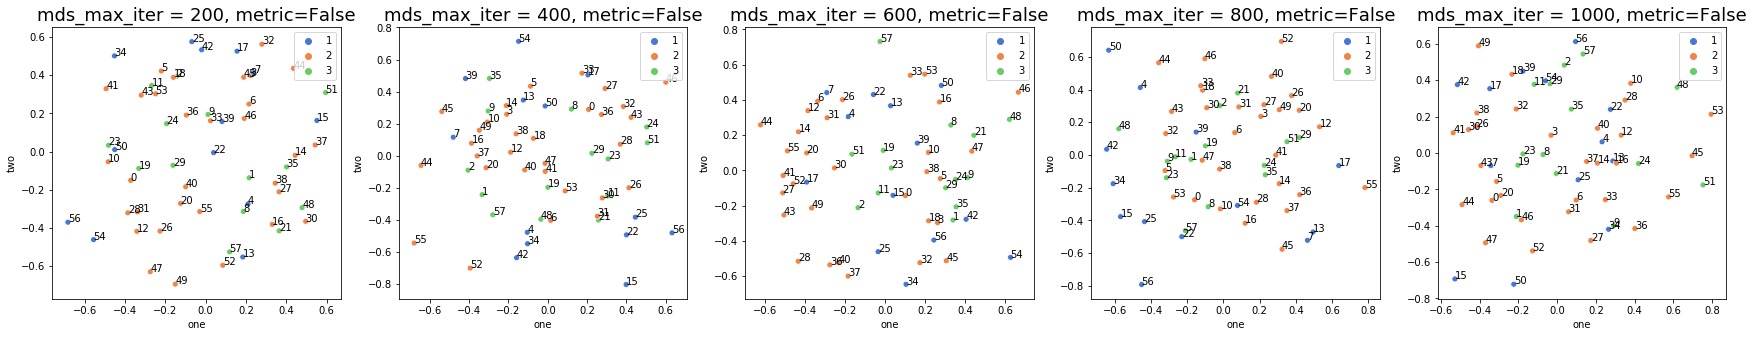

In [18]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = MDS(
        metric=False,
        max_iter=n*200,
        n_components=2)
    title='mds_max_iter = {}, metric={}'.format(n*200,False)
    draw_plot(fit, title, n, ax_list)

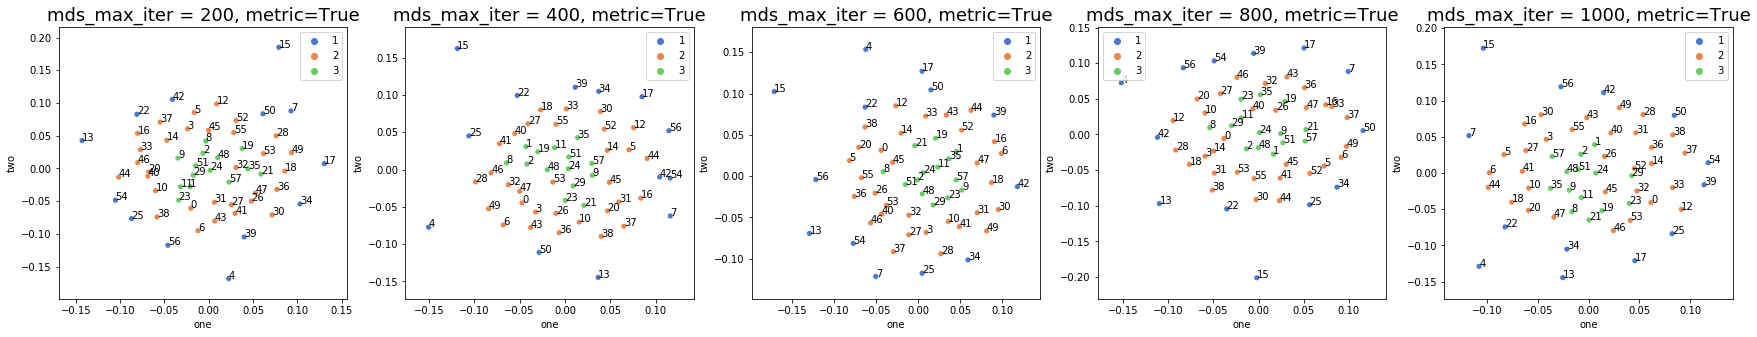

In [19]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = MDS(
        metric=True,
        max_iter=n*200,
        n_components=2)
    title='mds_max_iter = {}, metric={}'.format(n*200,True)
    draw_plot(fit, title, n, ax_list)

### Classifiers

In [20]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_normalized)

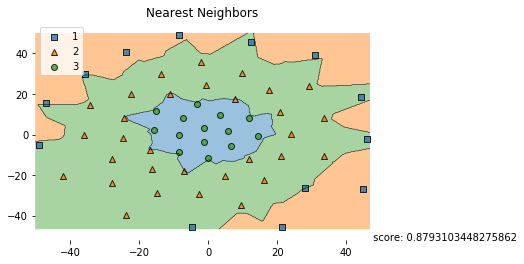

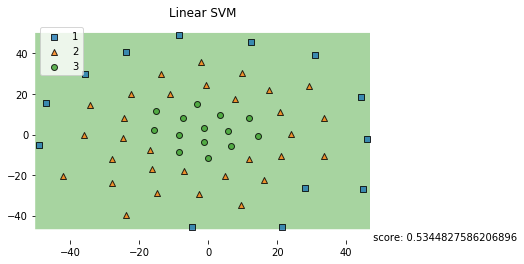

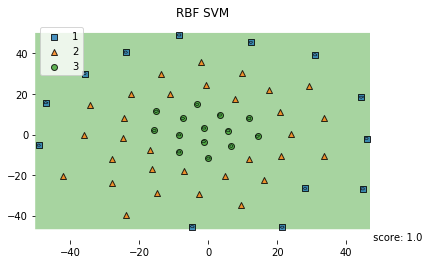

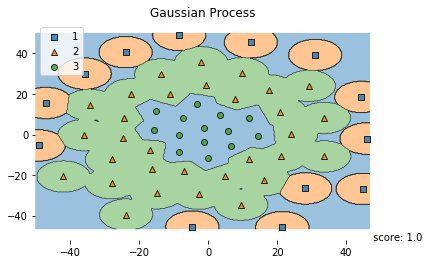

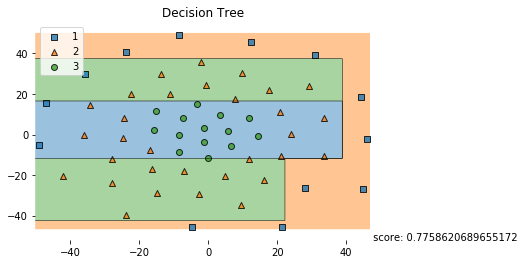

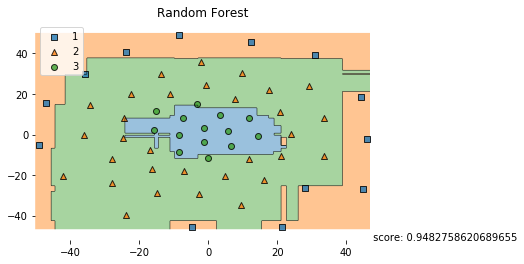

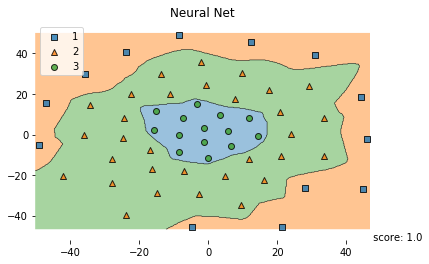

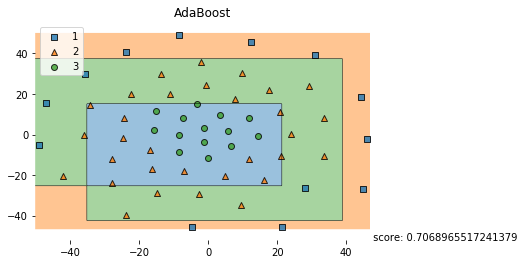

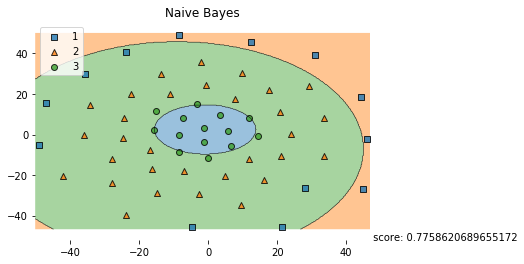

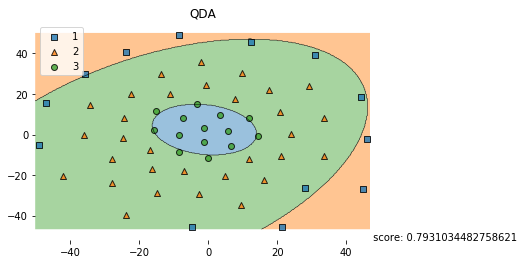

In [31]:
"""Classification on all data"""
#pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(tsne_results, days_groups)
    score = classifier.score(tsne_results, days_groups)
    
    plot_decision_regions(tsne_results, np.asarray(days_groups), clf=classifier, legend=2)
    plt.legend(loc='upper left')
    plt.title(names[i])
    plt.text(plt.xlim()[1], plt.ylim()[0],' score: '+str(score))
    plt.show()

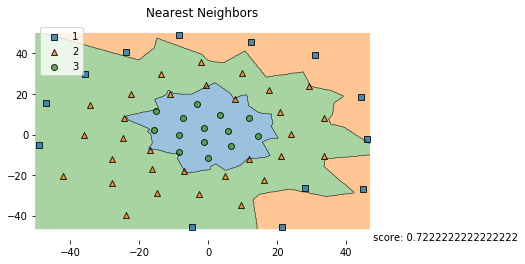

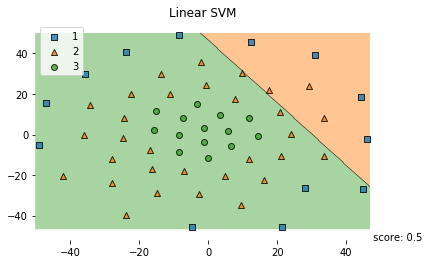

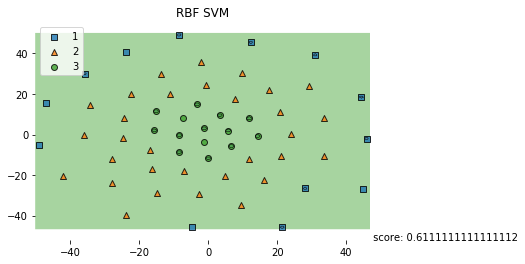

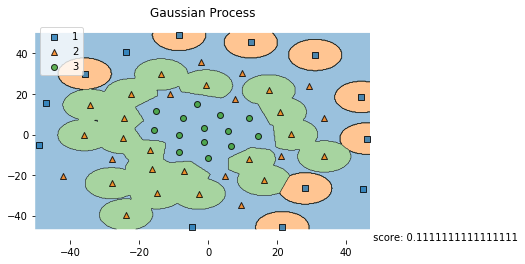

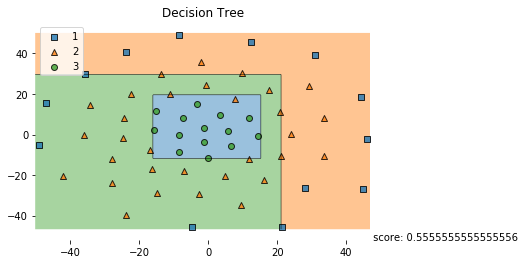

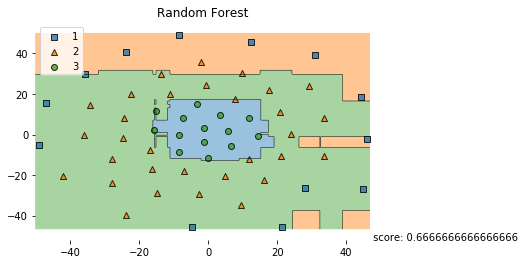

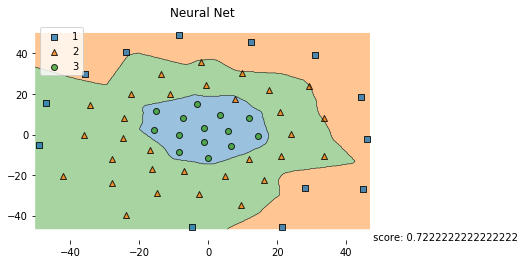

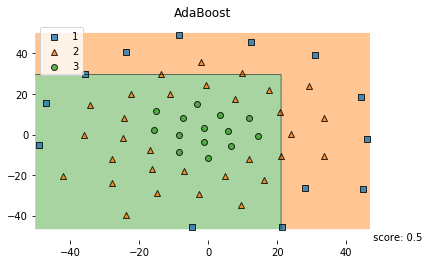

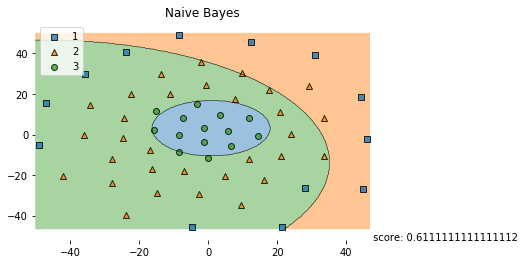

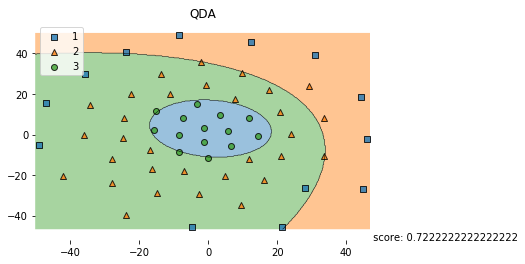

In [23]:
"""Classification on test data"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tsne_results, days_groups, test_size=.3, random_state=42)

for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)

    plot_decision_regions(tsne_results, np.asarray(days_groups), clf=classifier, legend=2)
    plt.legend(loc='upper left')
    plt.title(names[i])
    plt.text(plt.xlim()[1], plt.ylim()[0],' score: '+str(score))
    plt.show()